## <u>*Classsification Modelling for veh body as a Target Feature*</u>

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os

In [4]:
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRFClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials

---

In [5]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm","numclaims"],axis=1)
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.06,0.303901,0.0,HBACK,3,F,C,2
1,1.03,0.648871,0.0,HBACK,2,F,A,4
2,3.26,0.569473,0.0,UTE,2,F,E,2
3,4.14,0.317591,0.0,STNWG,2,F,D,2
4,0.72,0.648871,0.0,HBACK,4,F,C,2


In [6]:
df=df.sort_values(by=['veh_age', 'agecat','area','gender']).reset_index().drop("index",axis=1)
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.59,0.229979,0.0,SEDAN,1,F,A,1
1,1.46,0.221766,0.0,HBACK,1,F,A,1
2,1.54,0.238193,0.0,SEDAN,1,F,A,1
3,1.57,0.522930,0.0,SEDAN,1,F,A,1
4,1.41,0.219028,0.0,HBACK,1,F,A,1


*Date preprocessing*

In [7]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

In [8]:
df=df[df["claimcst0"]>0]
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
21,2.560,0.810404,11653.230000,4,0,0,0,0
40,1.399,0.862423,1259.189999,3,0,0,0,0
50,3.130,0.407940,850.830000,10,0,0,0,0
63,1.399,0.358658,367.730000,3,0,0,0,0
65,1.470,0.353183,200.000000,3,0,0,0,0


*Define x and y*

In [9]:
x=df.drop("veh_body",axis=1)
y=df["veh_body"]

In [10]:
df["veh_body"].value_counts()

veh_body
9     1476
3     1264
10    1173
12     260
4      130
11     120
2       68
7       62
6       43
5       14
0        9
1        3
8        2
Name: count, dtype: int64

*apply data balance method*

In [11]:
from imblearn.over_sampling import SMOTE
smk=SMOTE(random_state=41,k_neighbors=1)
x,y=smk.fit_resample(x,y)

*Splitting data into training and testing subsets*

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.25)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (14391, 7) and Y = (14391,) : 
Test data shape of X = (4797, 7) and Y = (4797,) : 


In [13]:
def evaluation_preds(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    metrics_dict={
       "accuracy": round(accuracy,3),
    }
    return metrics_dict

---

## *Hyperparamers tunning*

* *Defining models and its parameters*

In [24]:
models = {
        
        "XGBRFClassifier": XGBRFClassifier(),
        "GradientBoostingClassifier":GradientBoostingClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        
}

search_spaces ={        
        "XGBRFClassifier":{
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),    # 0.3 is the default
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            "subsample": hp.uniform("subsample",0.5,1.0),
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            'colsample_bytree': hp.uniform("colsample_bytree",0.5,1.0), 
            'colsample_bynode': hp.uniform("colsample_bynode",0.5,1.0),
            "reg_lambda": hp.quniform("reg_lambda",0,2,1),           #L2 regularization term on weights. Increasing this value will make model more conservative
            "reg_alpha": hp.quniform("reg_alpha",0,2,1),
            "num_parallel_tree": hp.choice("num_parallel_tree", [100,110])
            },
        "GradientBoostingClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            "max_depth": hp.choice("max_depth", [None,2, 4, 5, 6,7,8]),
            #"max_features": hp.choice("max_features",["sqrt", "log2"]),
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),
            "subsample": hp.uniform("subsample",0.8,1.0),
            "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
            "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0)
            },
        "RandomForestClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]), 
            "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
            "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
            #"bootstrap": hp.choice("bootstrap",[True, False]),                                                                                                    
            #"max_features": hp.choice("max_features",["sqrt", "log2"]),                                    
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            #"criterion": hp.choice("criterion",["gini", "entropy", "log_loss"])                    
        },
        "AdaBoostClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            "learning_rate": hp.uniform("learning_rate",0.01,1.0)
        },
        "DecisionTreeClassifier": {
                    "criterion": hp.choice("criterion",["gini", "entropy", "log_loss"]),
                    'splitter': hp.choice("splitter",["best", "random"]),
                    "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
                    "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
                    "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
                    "max_features": hp.choice("max_features",["sqrt", "log2"])
        }                    
}

In [14]:

print("===========================================rf_base_evaluation===========================================")
np.random.seed(42)
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
rf_base_evaluation=evaluation_preds(y_test,predicted)
print("RF_cross_val_evaluation_preds :\n" , rf_base_evaluation)
print("===========")

print("===========================================XGBRF_base_evaluation===========================================")
np.random.seed(42)
clf=XGBRFClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
XGBRF_base_evaluation=evaluation_preds(y_test,predicted)
print("RF_cross_val_evaluation_preds :\n" , XGBRF_base_evaluation)
print("===========")

print("===========================================ADAboost_base_evaluation===========================================")
np.random.seed(42)
clf=AdaBoostClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
ADAboost_base_evaluation=evaluation_preds(y_test,predicted)
print("RF_cross_val_evaluation_preds :\n" , ADAboost_base_evaluation)
print("===========")

print("===========================================GradientBoostingClassifier===========================================")
np.random.seed(42)
clf=GradientBoostingClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
GBOOST_base_evaluation=evaluation_preds(y_test,predicted)
print("RF_cross_val_evaluation_preds :\n" , GBOOST_base_evaluation)
print("==================================================================")  

===========================================rf_base_evaluation===========================================
RF_cross_val_evaluation_preds :
 {'accuracy': 0.867}
===========================================XGBRF_base_evaluation===========================================
RF_cross_val_evaluation_preds :
 {'accuracy': 0.708}
===========================================ADAboost_base_evaluation===========================================
RF_cross_val_evaluation_preds :
 {'accuracy': 0.186}
===========================================GradientBoostingClassifier===========================================
RF_cross_val_evaluation_preds :
 {'accuracy': 0.747}


In [15]:
np.random.seed(42)
basemodels=pd.DataFrame({
    "rf_base_evaluation":rf_base_evaluation,
    "ADAboost_base_evaluation":ADAboost_base_evaluation,
    "XGBRF_base_evaluation":XGBRF_base_evaluation,
    "GBOOST_base_evaluation":GBOOST_base_evaluation
})
basemodels

,rf_base_evaluation,ADAboost_base_evaluation,XGBRF_base_evaluation,GBOOST_base_evaluation
accuracy,0.867,0.186,0.708,0.747


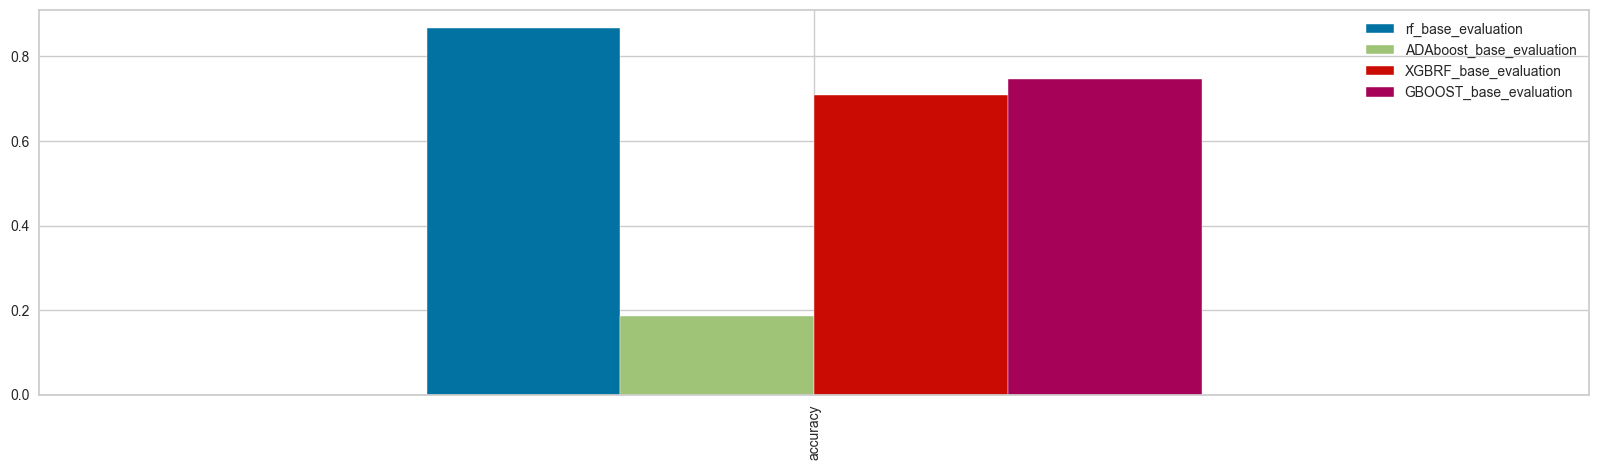

In [16]:
basemodels.plot(kind="bar",figsize=(20,5));

* *AdaBoostClassifier hyperparameter*

In [17]:
space=search_spaces["AdaBoostClassifier"]
def hyperparameter_tuning(space):
    clf = AdaBoostClassifier(**space)
    clf.fit(x_train,y_train)
    acc = accuracy_score(y_test,clf.predict(x_test))
    return {"loss": acc, "status": STATUS_OK}

trials = Trials()
best_AdaBoostClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [02:06<00:00, 12.65s/trial, best loss: 0.18678340629560142]


* *GradientBoostingClassifier hyperparameter*

In [25]:
space=search_spaces["GradientBoostingClassifier"]
def hyperparameter_tuning(space):
    clf = GradientBoostingClassifier(**space)
    clf.fit(x_train,y_train)
    acc = accuracy_score(y_test,clf.predict(x_test))
    return {"loss": acc, "status": STATUS_OK}

trials = Trials()
best_GradientBoostingClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)   

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [01:49<00:00, 10.95s/trial, best loss: 0.07087763185324161]


* *RandomForestClassifier hyperparameter*

In [19]:
space=search_spaces["RandomForestClassifier"]
def hyperparameter_tuning(space):
    clf = RandomForestClassifier(**space)
    clf.fit(x_train,y_train)
    acc = accuracy_score(y_test,clf.predict(x_test))
    return {"loss": acc, "status": STATUS_OK}

trials = Trials()
best_RandomForestClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)

100%|██████████| 10/10 [00:13<00:00,  1.35s/trial, best loss: 0.07087763185324161]


* *XGBRFClassifier hyperparameter*

In [20]:
space=search_spaces["XGBRFClassifier"]
def hyperparameter_tuning(space):
    clf = XGBRFClassifier(**space)
    clf.fit(x_train,y_train)
    acc = accuracy_score(y_test,clf.predict(x_test))
    return {"loss": acc, "status": STATUS_OK}

trials = Trials()
best_XGBRFClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)        

100%|██████████| 10/10 [03:13<00:00, 19.31s/trial, best loss: 0.4481967896602043]


In [26]:
print("===========================================best_AdaBoostClassifier===========================================")
model = AdaBoostClassifier(**best_AdaBoostClassifier)
model.fit(x_train,y_train)
predicted=model.predict(x_test)
print("evaluation_preds :\n" , evaluation_preds(y_test,predicted))
ADAboost_evaluation_preds=evaluation_preds(y_test,predicted) 
print("===========")

print("===========================================GradientBoostingClassifier===========================================")
model = GradientBoostingClassifier(**best_GradientBoostingClassifier)
model.fit(x_train,y_train)
predicted=model.predict(x_test)
print("evaluation_preds :\n" , evaluation_preds(y_test,predicted))
GBOOST_evaluation_preds=evaluation_preds(y_test,predicted)  
print("===========")

print("===========================================XGBRFClassifier===========================================")
model = XGBRFClassifier(**best_XGBRFClassifier)
model.fit(x_train,y_train)
predicted=model.predict(x_test)
print("evaluation_preds :\n" , evaluation_preds(y_test,predicted))
XGBRF_evaluation_preds=evaluation_preds(y_test,predicted)     
print("===========")

print("===========================================RandomForestClassifier===========================================")
model = RandomForestClassifier(**best_RandomForestClassifier)
model.fit(x_train,y_train)
predicted=model.predict(x_test)
print("evaluation_preds :\n" , evaluation_preds(y_test,predicted))
RF_evaluation_preds=evaluation_preds(y_test,predicted)
print("===========")

===========================================best_AdaBoostClassifier===========================================
evaluation_preds :
 {'accuracy': 0.187}
===========================================GradientBoostingClassifier===========================================
evaluation_preds :
 {'accuracy': 0.071}
===========================================XGBRFClassifier===========================================
evaluation_preds :
 {'accuracy': 0.757}
===========================================RandomForestClassifier===========================================
evaluation_preds :
 {'accuracy': 0.071}


In [27]:
import json
# Serializing json
json_object = json.dumps({
    "best_AdaBoostClassifier" : best_AdaBoostClassifier,
    "best_GradientBoostingClassifier" :best_GradientBoostingClassifier,
    "best_RandomForestClassifier" :best_RandomForestClassifier,
    "best_XGBRFClassifier" :best_XGBRFClassifier}, indent=4,default=str)
 
# Writing to sample.json
with open("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestParams/veh_body_classification_all_best_params.json", "w") as f:
    f.write(json_object)

In [28]:
import json
# Serializing json
json_object = json.dumps({"ADAboost_evaluation_preds" : ADAboost_evaluation_preds,
    "GBOOST_evaluation_preds" :GBOOST_evaluation_preds,
    "XGBRF_evaluation_preds" :XGBRF_evaluation_preds,
    "RF_evaluation_preds" :RF_evaluation_preds,
    "rf_base_evaluation":rf_base_evaluation,
    "ADAboost_base_evaluation":ADAboost_base_evaluation,
    "XGBRF_base_evaluation":XGBRF_base_evaluation,
    "GBOOST_base_evaluation":GBOOST_base_evaluation}, indent=4)
 
# Writing to sample.json
with open("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/modelsEvaluations/veh_body_classification_all_evaluations.json", "w") as f:
    f.write(json_object)

In [29]:
comparison=pd.DataFrame({
    "ADAboost_evaluation_preds" : ADAboost_evaluation_preds,
    "GBOOST_evaluation_preds" :GBOOST_evaluation_preds,
    "XGBRF_evaluation_preds" :XGBRF_evaluation_preds,
    "RF_evaluation_preds" :RF_evaluation_preds,
    "rf_base_evaluation":rf_base_evaluation,
    "ADAboost_base_evaluation":ADAboost_base_evaluation,
    "XGBRF_base_evaluation":XGBRF_base_evaluation,
    "GBOOST_base_evaluation":GBOOST_base_evaluation
})
comparison

,ADAboost_evaluation_preds,GBOOST_evaluation_preds,XGBRF_evaluation_preds,RF_evaluation_preds,rf_base_evaluation,ADAboost_base_evaluation,XGBRF_base_evaluation,GBOOST_base_evaluation
accuracy,0.187,0.071,0.757,0.071,0.867,0.186,0.708,0.747


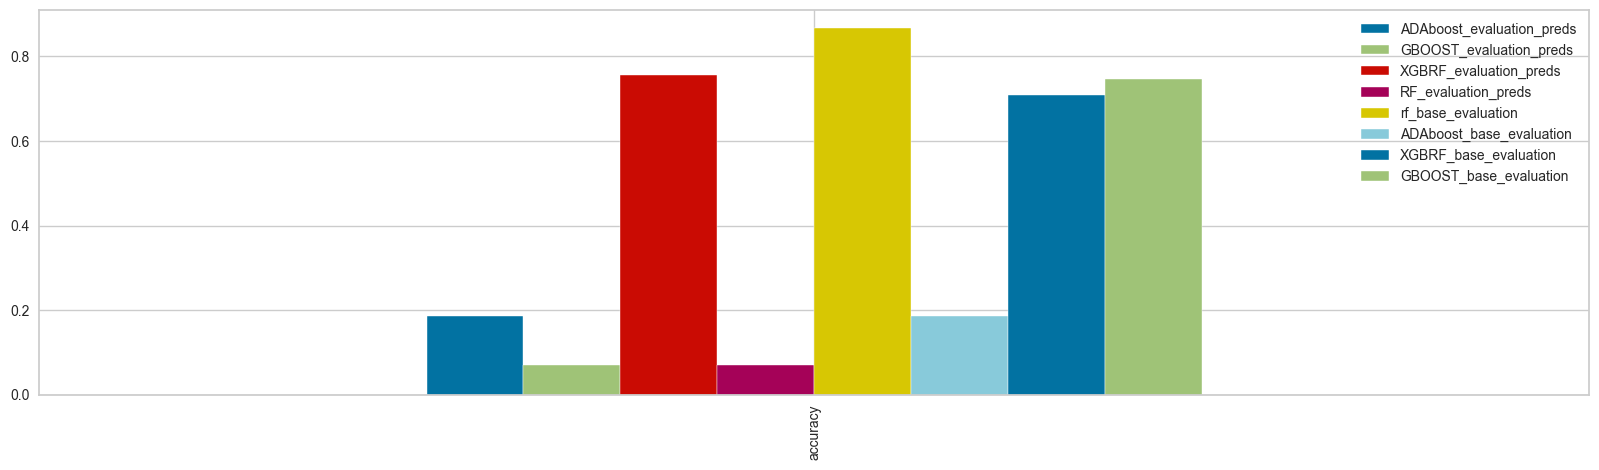

In [30]:
comparison.plot(kind="bar",figsize=(20,5))
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/modelsEvaluationsGraphs/veh_body_EvaluationsGraph.png',dpi=500); 

### *Final Result*

In [14]:
np.random.seed(42)
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
print(classification_report(y_test,predicted))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       351
           1       1.00      1.00      1.00       338
           2       0.89      0.97      0.93       350
           3       0.60      0.62      0.61       358
           4       0.90      0.94      0.92       357
           5       1.00      1.00      1.00       359
           6       0.94      0.98      0.96       368
           7       0.91      0.98      0.94       337
           8       0.99      1.00      1.00       391
           9       0.56      0.42      0.48       418
          10       0.77      0.63      0.70       394
          11       0.91      0.95      0.93       412
          12       0.80      0.89      0.84       364

    accuracy                           0.87      4797
   macro avg       0.87      0.88      0.87      4797
weighted avg       0.86      0.87      0.86      4797



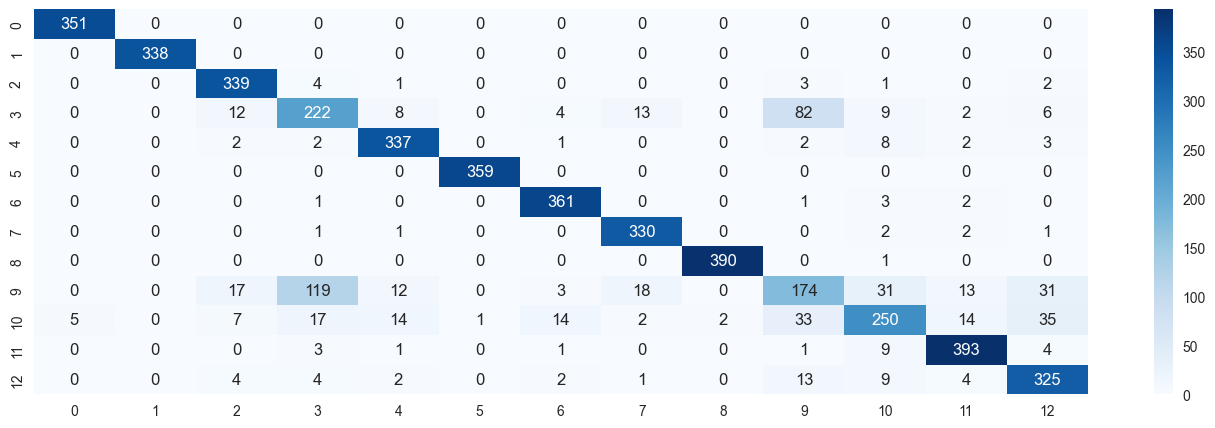

In [15]:
fig=plt.figure(figsize=(17,5))
sns.heatmap(confusion_matrix(y_test,predicted),annot = True, fmt = ".0f",cmap="Blues")
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/confusionMatrixGraphs/veh_body_confusion_matrixPlot.png',dpi=500); 

In [16]:
pd.crosstab(y_test,predicted,rownames=["Actual"],colnames=["predicted"])

predicted,0,1,2,3,4,5,6,7,8,9,10,11,12
Actual,,,,,,,,,,,,,
0,351,0,0,0,0,0,0,0,0,0,0,0,0
1,0,338,0,0,0,0,0,0,0,0,0,0,0
2,0,0,339,4,1,0,0,0,0,3,1,0,2
3,0,0,12,222,8,0,4,13,0,82,9,2,6
4,0,0,2,2,337,0,1,0,0,2,8,2,3
5,0,0,0,0,0,359,0,0,0,0,0,0,0
6,0,0,0,1,0,0,361,0,0,1,3,2,0
7,0,0,0,1,1,0,0,330,0,0,2,2,1
8,0,0,0,0,0,0,0,0,390,0,1,0,0


In [17]:
clf.feature_names_in=x.columns
importance=pd.concat([pd.DataFrame(clf.feature_names_in,columns=["feature_names"]),
           pd.DataFrame(clf.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.246455
1,exposure,0.172487
2,claimcst0,0.227839
3,veh_age,0.108678
4,gender,0.041507
5,area,0.113756
6,agecat,0.089278


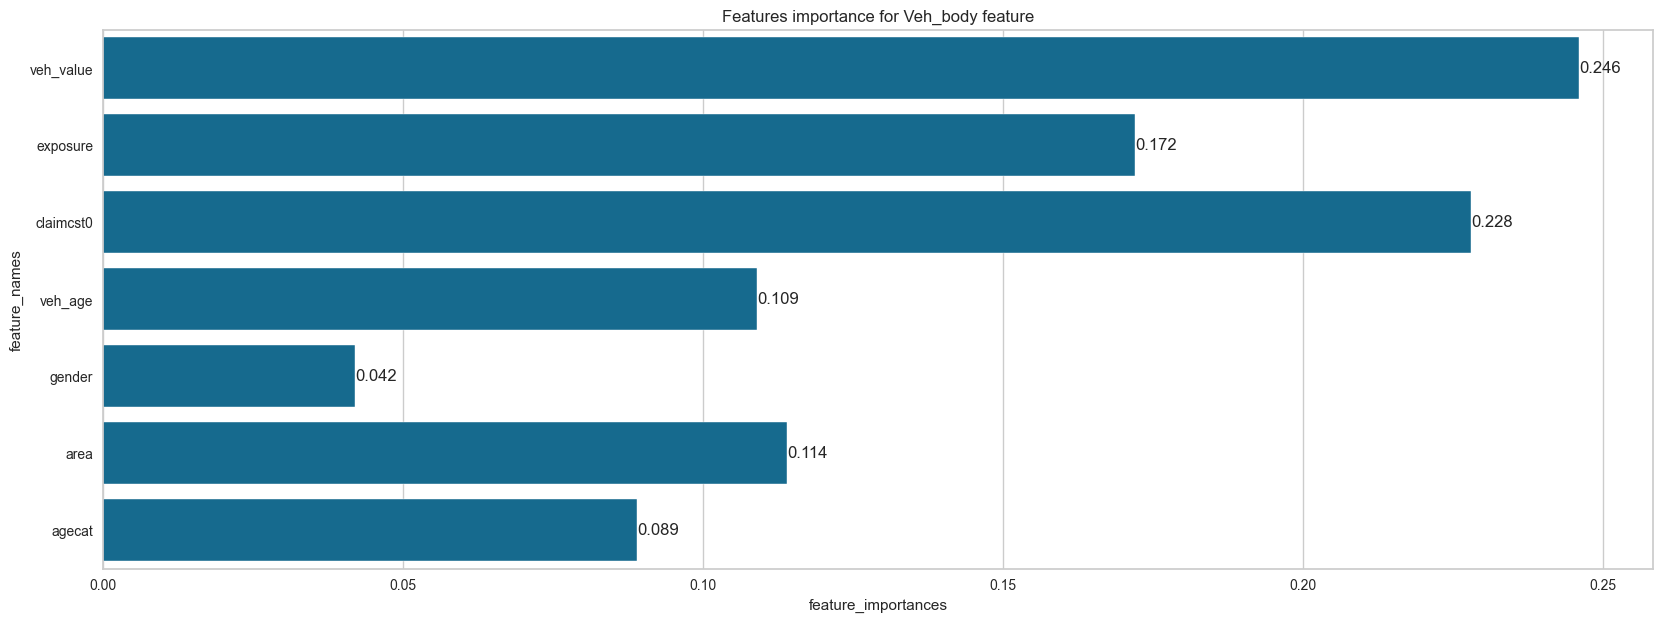

In [18]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for Veh_body feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/veh_body_featureImportanc.png',dpi=500);

In [19]:
import joblib
joblib.dump(clf, "C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/veh_body_prediction_model.joblib")

['C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/veh_body_prediction_model.joblib']